# Introduction to Time Series Anaysis

### Data Science 350
### Stephen Elston

## Introduciton

This notebook provides an overview of time series analysis. Time series are an extremely common data type. Just a few of the many applications of time series analysis include:

- **Demand forecasting:** Electricity production, Internet bandwidth, Traffic management, Inventory management
- **Medicine:** Time dependent treatment effects, EKG, EEG
- **Engineering and Science:** Signal analysis, Analysis of physical processes
- **Capital markets and economics:** Seasonal unemployment, Price/return series, Risk analysis

This notebook covers the  following topics:

- Basic properties of time series.
- Decomposition of time series.
- Modeling of time series residuals and the ARIMA model.

***
**Note** To run this notebook, you must install the `forecast` package.  
***


## Short History of Time Series Analysis

The history of time series analysis starts with the pionering work of George Udny Yule (published 1927) and Gilber Walker (Published 1931). Both Yule and Walker worked on the auto regresive (AR) model for stochastic time series.

![](img/George_Udny_Yule.jpg)
<center> **George Yule; time series pioner**

Mathematical prodegee, Norbert Weiner invented filters for stochastic time series processes during the Second World war. Weiner worked at MIT and was assigned to a project to immrove the accuracy of anti-aircraft guns using the noisy radar signals of the day. He published his seminal paper on the subject in 1949. If you have recently used a mobile phone or streamed video or audio you are reciving benefits of wiener's research!

![](img/Norbert_wiener.jpg)
<center> **Norbert Weiner: Invented time series filter**

George Box and Gwilym Jenkins fully developed the the statistical theory  of time series by extending the work of Yule and Walker in the 1950s and d 1960s. This work was fully developed in thier seminal 1970  book. Their theory included the auto regressive moving averge (ARMA) model and the auto regressive integrfated moving averge (ARIMA) models we use in this notebook.

George Box was maired to Joan Fisher Box, an outstanding statistician in her own right and daughter of Ronald Fisher. 

![](img/GeorgeEPBox.jpg)
<center> **George Box fully developed the ARIMA model**

![](img/BoxJenkins.jpg)
<center> **Seminal book: by Box and  Jenkins**

## References

The book by Paul Cowpertwait and Andrew Metcalfe, *Introductory Time Series with R*,Springer, 2009,is good introduction to time series analysis. This book includes copious examples using R. 

![](img/Cowpertwait.jpg)

A more comprehensive treatment of time series theory can be found in a number of books. *Time Series Analysis With Applications in R* by Jonathan Cryer and Kung-Sik Chan, Springer, 2010, is both comprehensive and readable. However, the R code examples are sparse and poorly organized.

![](img/Cryer.jpg)

A comprehensive list of R time series packages can be found in the [CRAN Time Series Task View](https://cran.r-project.org/web/views/TimeSeries.html)

## Working with Time Series in R

R contains a number of time series classes. In this notebook we will work with the basic `ts` class. A powerful `zoo` class provides more capabilities. The `xts` package adds extensibility to the `zoo` class. Many other R time series classes are available. 

Let's create a simple R `ts` class time series object. Execute the code in the cell below to create a vector of values from a `sin` function. Note the class of the resulting vector. 

In [3]:
vec = sin((1:365)/30)  # A vector of values
class(vec) # Vector is an atomic class in R

[1] "numeric"

You have creted a numeric vector.

The code in the cell below does the following:

- The class of the vector is converted to `ts` with attributes of a start date and a frequecy.
- The class and attributes of the of the time series are printed.
- The time series is plotted using the `ts` plot method.

Execute this code and examine the results. 

$tsp
[1] 1990.000 1990.997  365.000

$class
[1] "ts"

Loading required package: repr
Warning message:
"package 'repr' was built under R version 3.3.2"

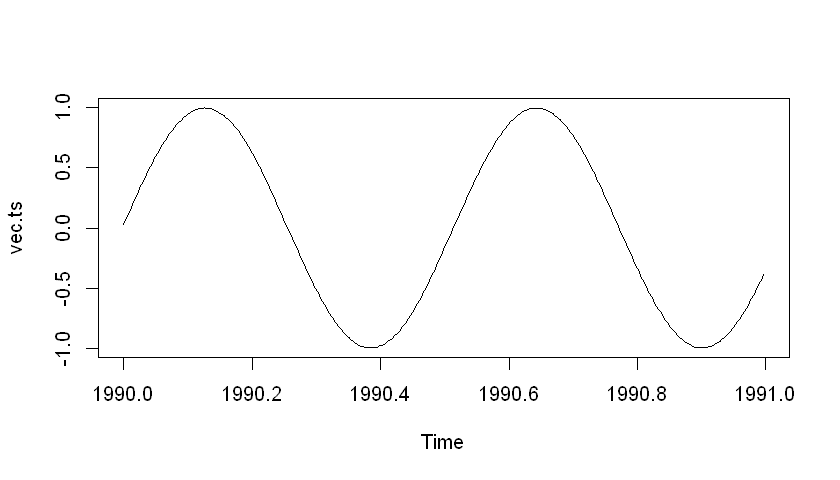

In [4]:
## Create a ts class object from the vector
## by adding time series attributes
vec.ts = ts(vec, start = 1990/01/01, freq = 365)
attributes(vec.ts) # Note the time series attributes
require(repr)
options(repr.pmales.extlot.width=8, repr.plot.height=4)
plot(vec.ts) # Note the x-axis is the time attribute

The vector is now of class `ts`. The attributes include the start time, end time and frequency. The plot shows the time series values on the vertical axis and the calendar date on the horizontal axis. 

In summary, a time series object is an ordinary vector, matrix of data frame with special attributes. 

## Properties of Basic Time Series

In this section we will explore some basic properties time series. Underrstnding these properties will help in understanding the models we explore in subsequent sections.

### Properties of White Noise Series

A random series drawn from independent identically distributed (iid) noise drawen from a Normal distribution. Such a series is said to be a **white noise** series. Since the series is iid there is no correlation from one value to the next. We can write this series as just:

$$Y = (y_1, y_2, y_3, \dots, y_n)\\
where\\
y_t = w_t = N(0, \theta)$$

Notice that the standard deviation and therefore the variance of the series, $\theta$, is constant in time. We say that a time series with a constant variance is **stationary**.

The code in the cell below creates a time series from an iid Normal distribution with mean zero. Execute this code and note the attributes and the plot.

$tsp
[1] 1990.000 2004.917   12.000

$class
[1] "ts"

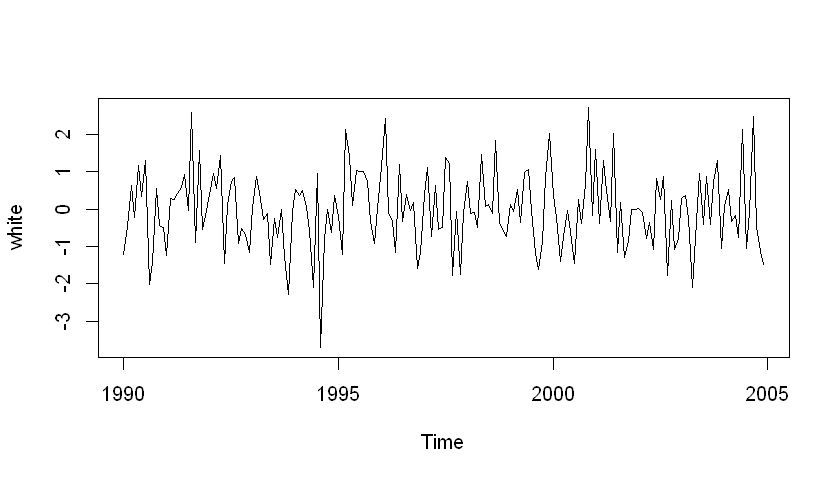

In [5]:
options(repr.pmales.extlot.width=8, repr.plot.height=4)
ts.white = function(n, mean = 0.0, sd = 1.0, start = 1990, freq = 12){
  ts(rnorm(n, mean = mean, sd = sd), start = start, freq = 12)
}
white = ts.white(180)
attributes(white)
plot(white)

Notice that the values of the time series move wander randomly around zero, with no particular trend. 

Next, let's look at the distribution of the time series values. The code in the cell below plots the histogram and Q-Q Normal plot of the values of the time series. Run this code and examine the results.  

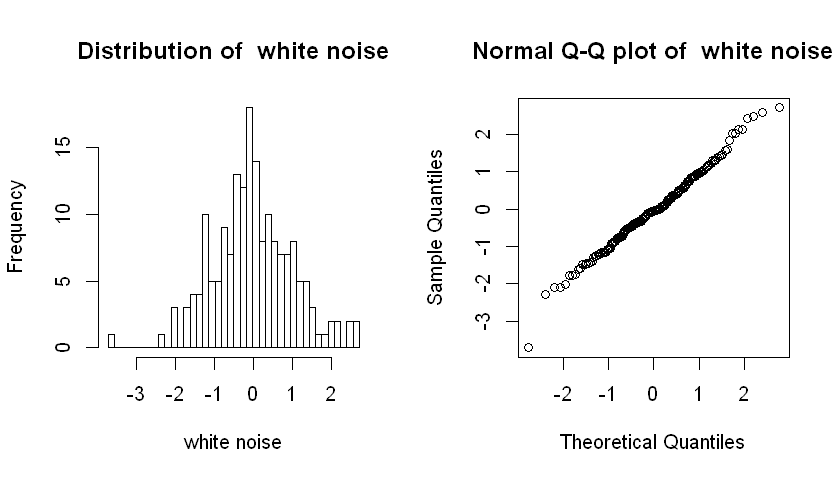

In [6]:
dist.ts = function(df, col = 'residual', bins = 40){
  par(mfrow = c(1,2))
  temp = as.vector(df)
  breaks = seq(min(temp), max(temp), length.out = (bins + 1))
  hist(temp, breaks = breaks, main = paste('Distribution of ', col), xlab = col)
  qqnorm(temp, main = paste('Normal Q-Q plot of ', col))
  par(mfrow = c(1,1))
}
dist.ts(white, col = 'white noise')

As expected, the values of the white noise series are normalilly distributed. When examining these plots keep in mind there are only 180 values. 

The values of the white noise series are iid, so we do not expect the values to show any dependency over time. In time series analysis we measure dependency using **autocorrelation**. Autocorrelation is the correlation of a series with itself lagged (off set) by some number of time steps. Autocorrelation at lag k can be writen as:

$$\rho_k = \frac{\gamma_k}{n \sigma^2} = \frac{1}{n \sigma^2} {\Sigma_{t = 1}^N (x_{t} - \mu) \cdot (x_{t-k} - \mu)}\\
where\\
k = lag\\
\gamma_k = covariance\ lag\ k\\
\mu = mean\ of\ the\ series\\
\sigma^2 = variance\ of\ the\ serries = \frac{1}{n-1}\Sigma_{t = 1}^N (x_{t} - \mu) \cdot (x_{t} - \mu)$$

Notice that for any series, $\rho_0 = 1$. in other words, the autocorrleation of a series at lag zero equals one. 

We can also define a second order **partial autocorrelation**. The Partial autocoorelation at lag k is the correlation that results from removing the effect of any correlations due to the terms at smaller lags.

Let's plot the autocorrelation function (acf) and partial autocorrelation function (pacf) of the white noise series. Run the code in the cell below to compute and plot these functions. 

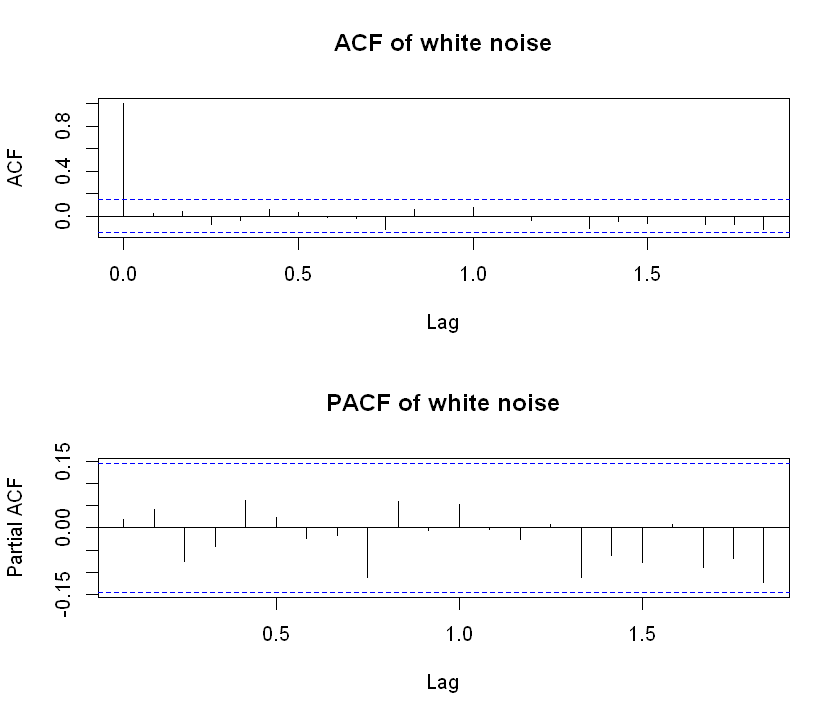

In [7]:
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf <- function(df, col = 'remainder', is.df =TRUE){
  if(is.df) temp <- df[, col]
  else temp <- df
  par(mfrow = c(2,1))
  acf(temp, main = paste('ACF of', col))
  pacf(temp, main = paste('PACF of', col))
  par(mfrow = c(1,1))
}
      plot.acf(white, col = 'white noise', is.df = F)

As expected the white noise series only has a significant value at lag zero. There are no significant partial autocorrelation values. The dotted line is the 95% confidence interval. 

### Random Walks

A **random walk** is the defined by the sum of a white noise series. In other words, the value of the random walk is the cumulative sum of the preceeding white noise series. 

$$y_t = y_{t-1} + w_t\\
Or\\
w_t = y_t - y_{t-1}$$ 

The quantities $y_t - y_{t-1}$ are known as the *innovations* of the random walk.

But note that for a random walk the covariance is not bounded.

$$\gamma_k = Cov(x_t, x_{t+k}) = t \sigma^2 \rightarrow \infty\ as\ t \rightarrow \infty$$

Further, the random walk is not stationary as the covariance increases with time. 

The code in the cell below computes a random walk series by taking the cumulative sum over Noramlly distributed inovations. Run this code and examine the results. 

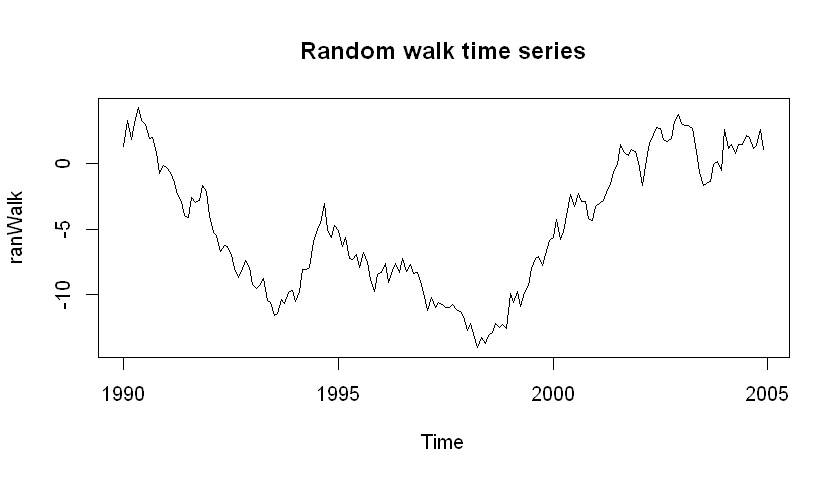

In [8]:
## Investigate the time series properties of random walk
options(repr.pmales.extlot.width=8, repr.plot.height=4)
ran.walk = function(n, freq = 12, start = 1990, sd = 1.0, mean = 0.0){
  norms = rnorm(n, mean = mean, sd = sd)
  ts(cumsum(norms), start = start, freq = 12)
}
ranWalk = ran.walk(180)
plot(ranWalk, main = 'Random walk time series')

The random walk wanders back and forth, but eventually heads in a particular direction. 

But what does the distribution of values of the random walk look like. Run the code in the cell below and examine the result. 

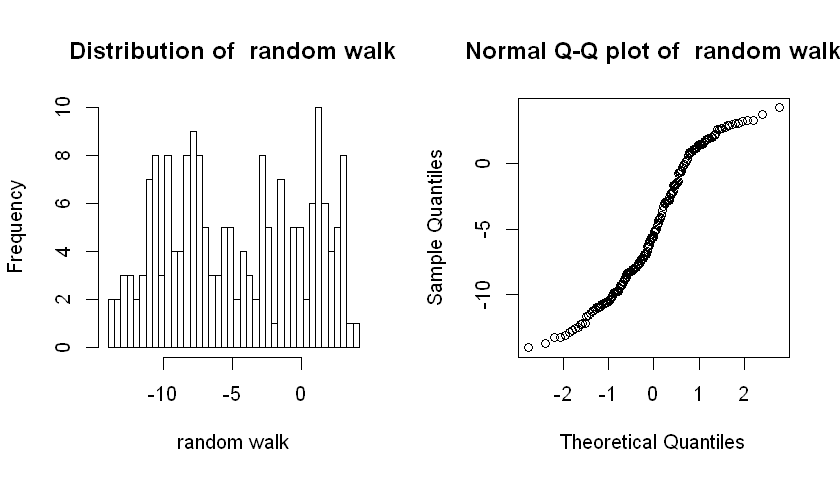

In [9]:
dist.ts(ranWalk, col = 'random walk')

The values of the random walk are essentially Normally distributed! On reflection this makes sense, since the inovations drawn from a Normal distribution.

What about the ACF and PACF of the random walk? Execute the code in the cell below to compute and plot the ACF and PACF. 

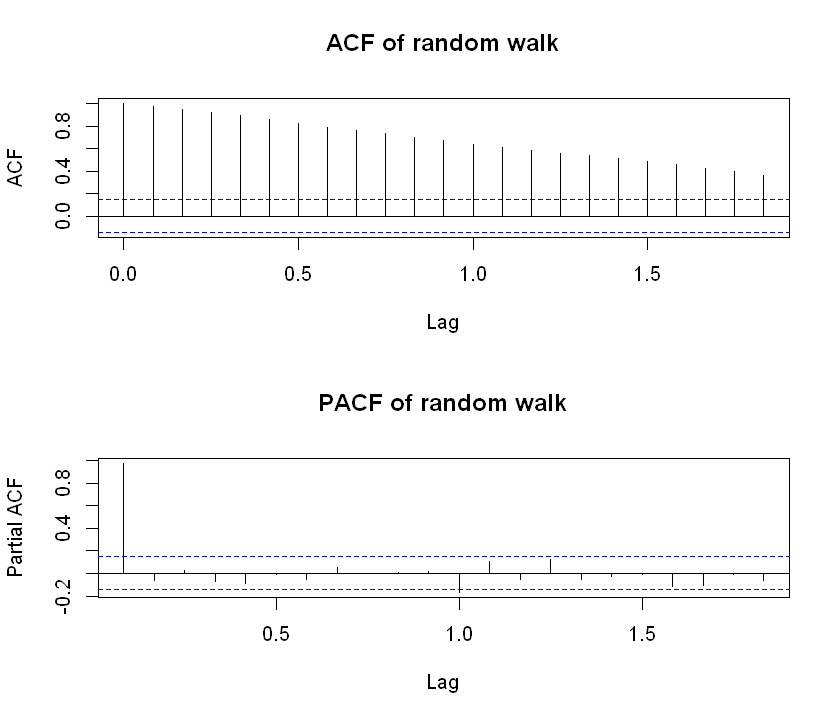

In [10]:
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(ranWalk, col = 'random walk', is.df = F)

The ACF values decay only slowly with lag. These results arrise from the correlation from one value to the next. 

### White Noise Series with Trend

What happens when we add a trend to the a white noise serie? Run the code in the cell below adds a linear trend to a white noise series. 

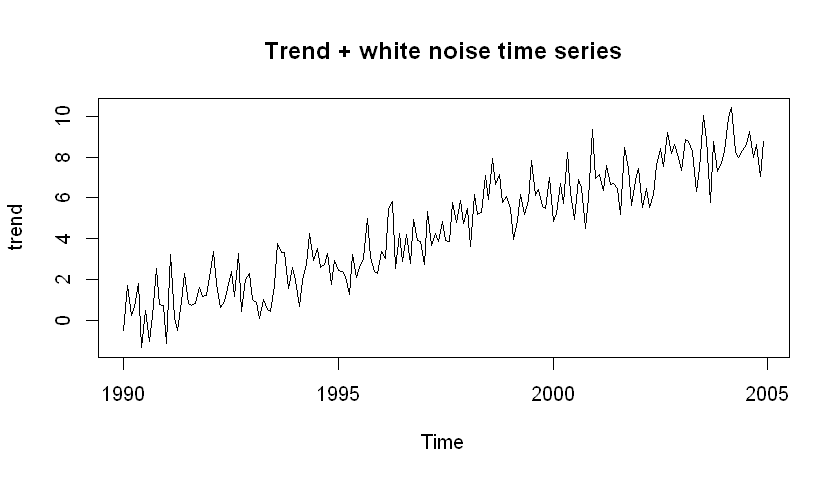

In [40]:
## ---- Investigate time series properties of 
## trend + white noise
options(repr.pmales.extlot.width=8, repr.plot.height=4)
ts.trend = function(n, slope = 0.01, mean = 0.0, sd = 1.0, start = 1990, freq = 12){
  temp = seq(0, slope * n, length.out = n) + 
          rnorm(n, mean = mean, sd = sd)
  ts(temp, start = start, freq = 12)
}
trend = ts.trend(180, slope = 0.05)
plot(trend, main = 'Trend + white noise time series')

As expected, the time series trends upward with a linear trend with iid Normal deviations. 

Run the code in the cell below to examine the distribution of values in this time series.

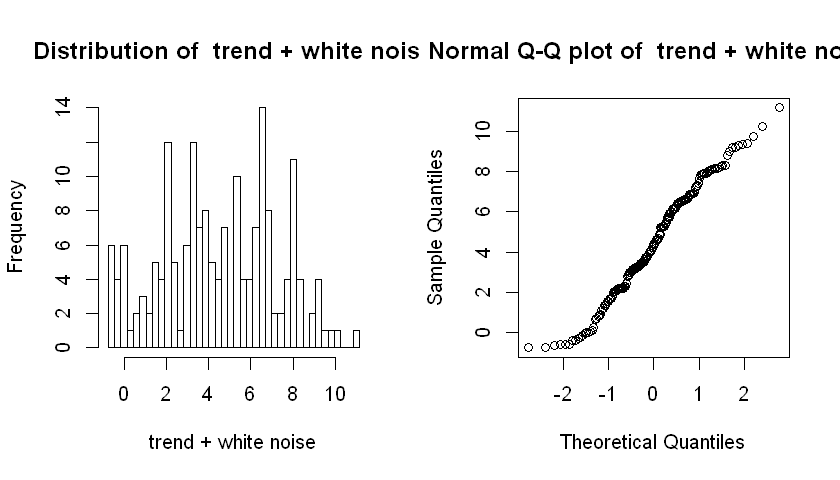

In [39]:
dist.ts(trend, col = 'trend + white noise')

The distribution is mostly Normal, but with heavy tails. 

How does adding a trend change the ACF and PACF? Run the code in the cell below and examine the results. 

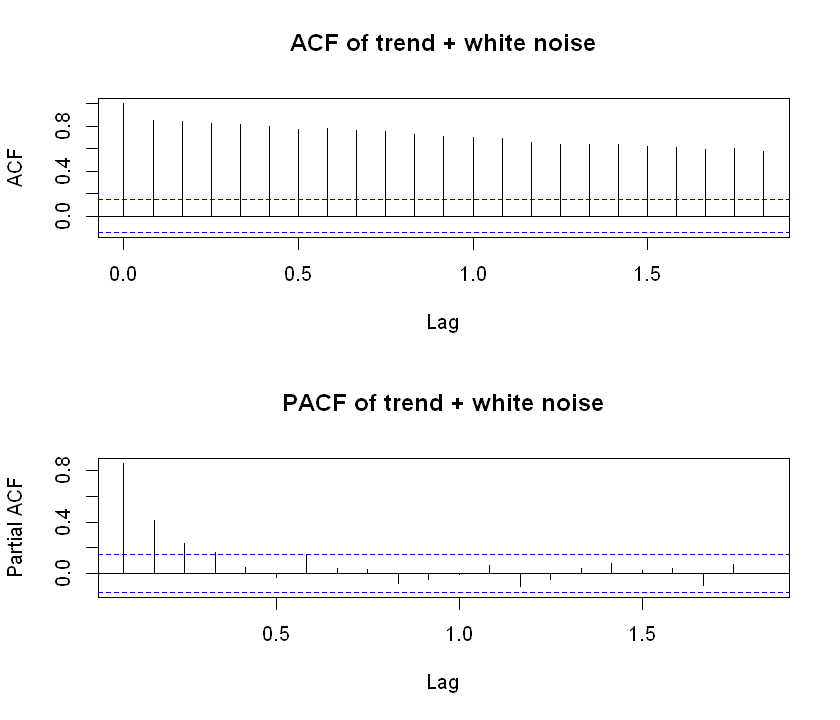

In [42]:
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(trend, col = 'trend + white noise', is.df = F)

Note the that the ACF decays slowly, as was the case with the random walk. In additon, the PACF shows significant values for at least one lag. This is the result of the trend creating dependency from one value to the next. 

### Time Series with a Seasonal Component

Many real-world tine series include a seasonal component. A seasonal component is a period variation in the values of the time series. The periods can be measured in years, months, days, days of the week, hours of the day, etc. Some examples of seasonal components of time series inclde:

- Opion expiration dates in capital markets.
- Anual holidays which can affect transportation, utility use, shopping habits, etc.
- Weekend vs. business days, which account for volumns of certian transaction behavior.
- Month of the year which can affect emploiyment patterns, weather, etc.

Let's investigate the properties of a time series with a seasonal component. The coded in the cell below creates and plots a time series with sinusoidal seasonal component added to White noise. Run this coded and examine the results.

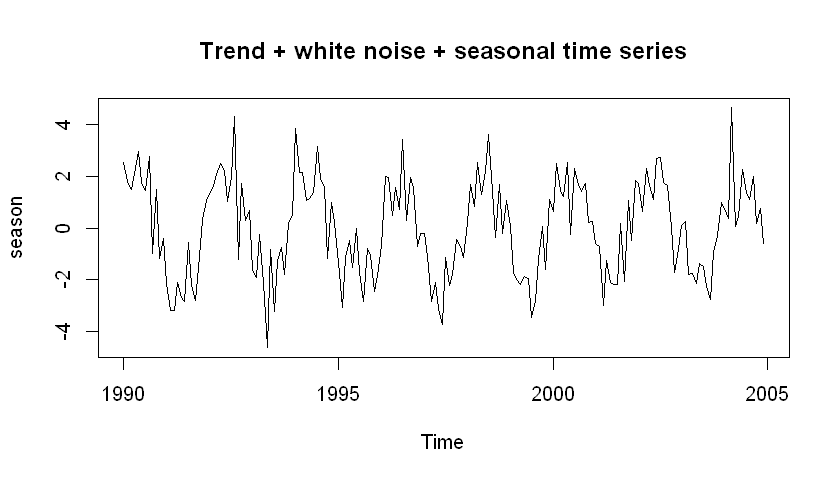

In [52]:
## --- Investigate time series properties of 
## trend + white noise + seasonal
ts.season = function(n, slope = 0.01, mean = 0.0, sd = 1.0, start = 1990, freq = 12){
   temp = seq(0, slope * n, length.out = n) + 
    rnorm(n, mean = mean, sd = sd) +
    2 * sin(0:(n -1) * pi / freq) +
     cos(0:(n -1) * pi / freq)
  ts(temp, start = start, freq = 12)
}
season = ts.season(180, slope = 0.00)
options(repr.pmales.extlot.width=8, repr.plot.height=4)
plot(season, main = 'Trend + white noise + seasonal time series')

As expected the time series looks like a noisy sin wave.

Run the code in the cell below to examine the distribution of these data.

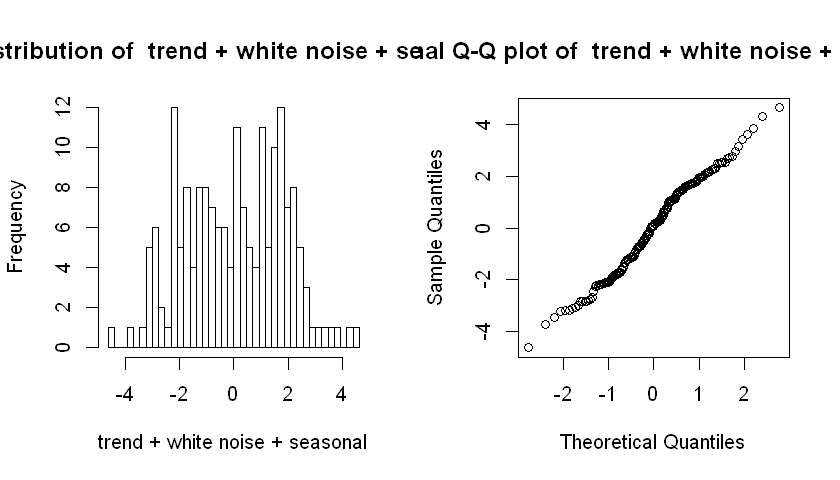

In [53]:
options(repr.pmales.extlot.width=8, repr.plot.height=4)
dist.ts(season, col = 'trend + white noise + seasonal')

These data are close to normally distributed, but with some variabtion from the seasonal component.

Next, execute the code in the cell below to plot the ACF and PACF of the series. 

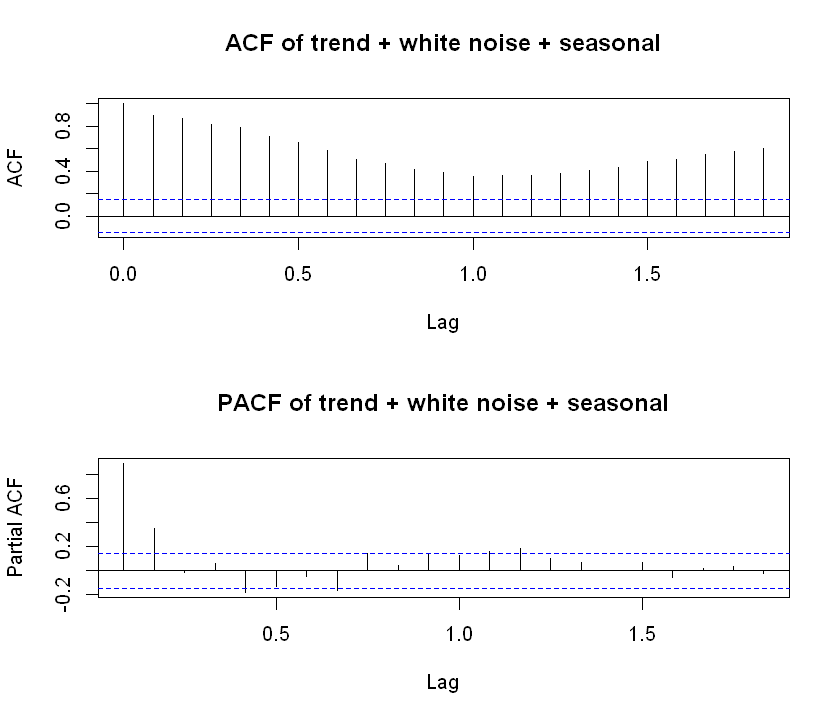

In [51]:
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(season, col = 'trend + white noise + seasonal', is.df = F)

Notice that the ACF both decays slowly, and shows a second hump caused by the seasonal component. The PACF has two significant lag values, indicating the dependency in values from the seasonal component. 

## Decomposition of Time Series

We have looked at the properties of several types of time series. 

- White noise series.
- Random walks.
- White noise series with trend.
- White noise series with seasonal component.

Next, we have to look into methods for decomposing time series data into its **trend, seasonal and residual** components.

### The STL Decomposition Models

A direct decomposition model is know as the **seasonal, trend and residual** or **STL** model. Not too surprisingly this model does the following:

- The trend is removed using a LOESS regression model. 
- The seasonal component is removed using a regression on periodic components.
- The remainder is know as the residual. 

The decomposition can be either additive or multiplicative. The additive model simply sums the componets and is writen:

$$TS(t) = S(t) + T(t) + R(t)$$

The multiplicative model multiplies the three components. This model is particuarly useful in the common case where the seasonal effect increases in proportional to the trend. We can write this  model as follows:  

$$TS(t) = S(t)\ *\ T(t)\ *\ R(t)\\
or\\
log(TS(t)) = S(t) + T(t) + R(t)$$

You can find details of this model in [Rob Hyndman's lecture notes](http://robjhyndman.com/uwafiles/5-Cross-validation.pdf). 

Let's try this out on a time series which has a seasonal, trend and white noise residual component. Run the code below to compuute the model and plot the results.

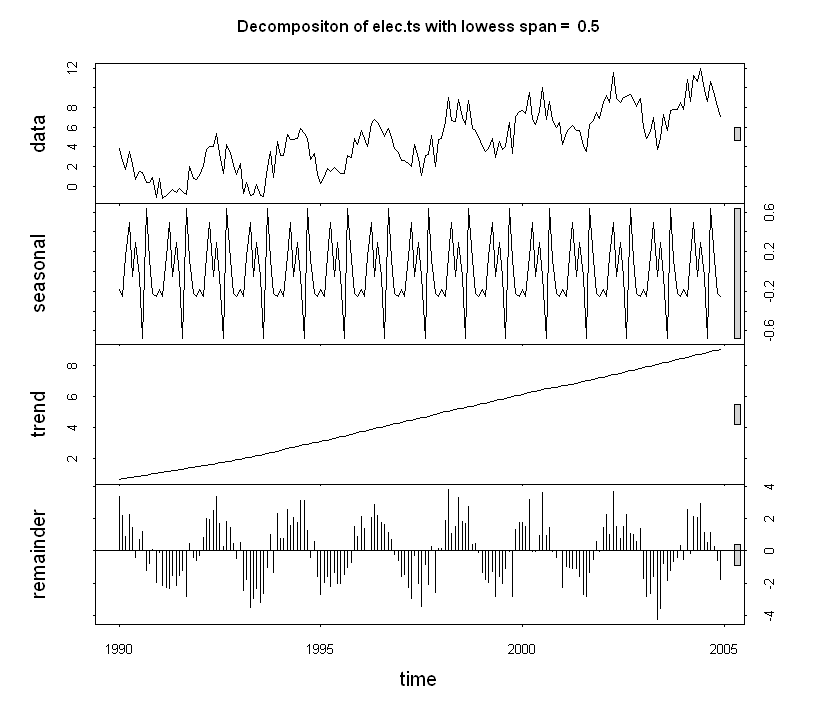

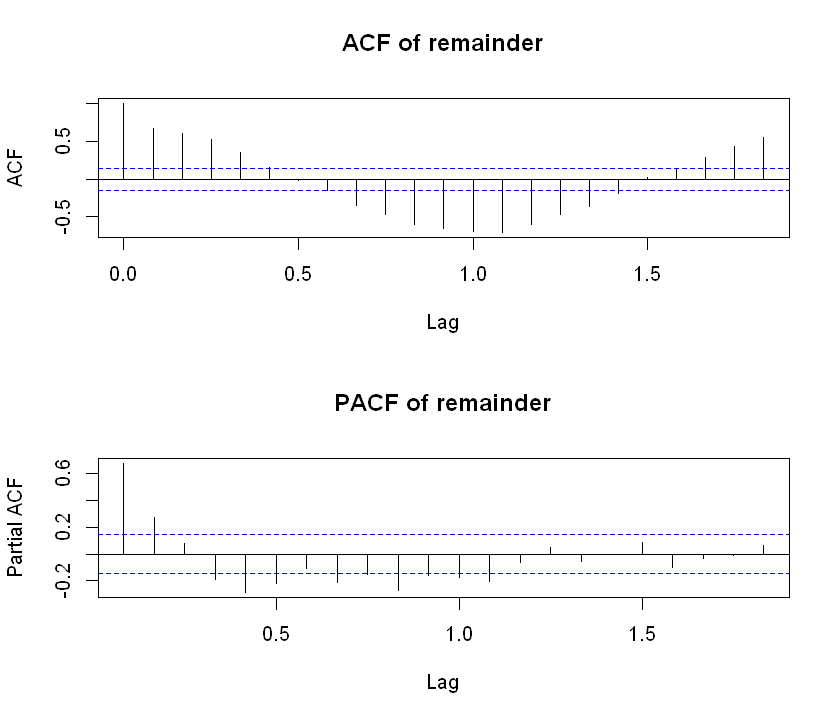

In [62]:
## Decomposition of the time series into components
ts.decomp <- function(df, col = 'elec.ts', span = 0.5, Mult = TRUE, is.df = TRUE){
  # if(Mult) temp = log(df[, col])  else temp = ts(df[, col]
  if(is.df) temp = log(df[, col])  
  else temp = df
  spans = span * length(temp)  
  fit <- stl(temp, s.window = "periodic", t.window = spans)
  plot(fit, main = paste('Decompositon of',col,'with lowess span = ', as.character(span)))
  fit$time.series
}
season.trend = ts.season(180, slope = 0.05)      
temp = ts.decomp(season.trend, is.df = FALSE, Mult = FALSE)
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(temp[,3], is.df = FALSE)

The STL model appears to have done a good job of removing the trend. However, the sesonal component is affected by the noise, which results in odd behavior of the residual.

### Difference Model for Random Walk

How do we deal with a random walk component? Reeall that the random walk is modeled as a cumulative sum (or integral in the continuious case) over the innovations. By takeing the differences (or derivatives in the continuious case) we can recover the innovations as a residual series.

The code in the cell below using the `diff` function for time series to compute the difference in the random walk series. Execute this code and examine the result.  

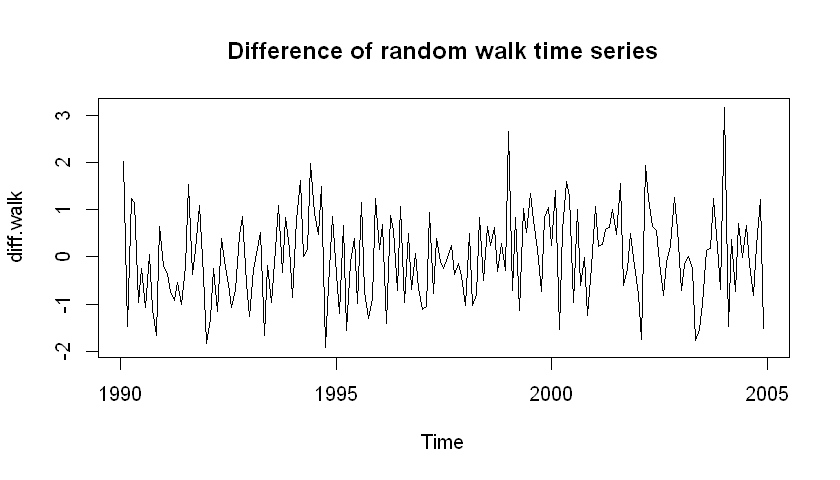

In [64]:
## Use a first order difference series to 
## remove the trend
ts.diff <- function(ts, lag = 1){
  diff(ts, lag = lag)
}
diff.walk = ts.diff(ranWalk)
options(repr.pmales.extlot.width=8, repr.plot.height=4)
plot(diff.walk, main = 'Difference of random walk time series')

The diference series resembles an iid white noise series. 

Run the code in the cell below to examine the distribution plots, the ACF and the PACF of the diference of the random walk series.

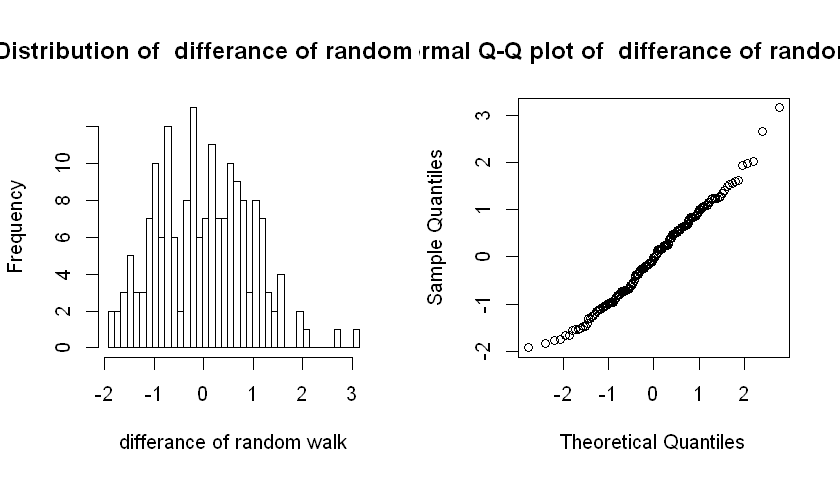

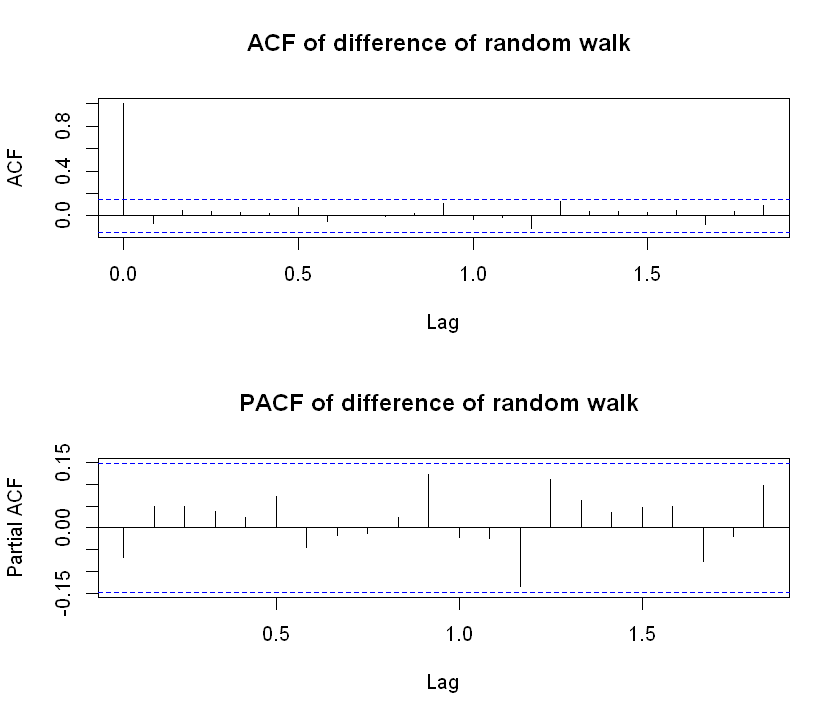

In [65]:
options(repr.pmales.extlot.width=8, repr.plot.height=4)
dist.ts(diff.walk, col = 'differance of random walk')
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(diff.walk, col = 'difference of random walk ', is.df = F)

The distribution of the difference series values are close to Normal. The ACF and PACF plots verify that the difference series is a white noise.

### An example on real data

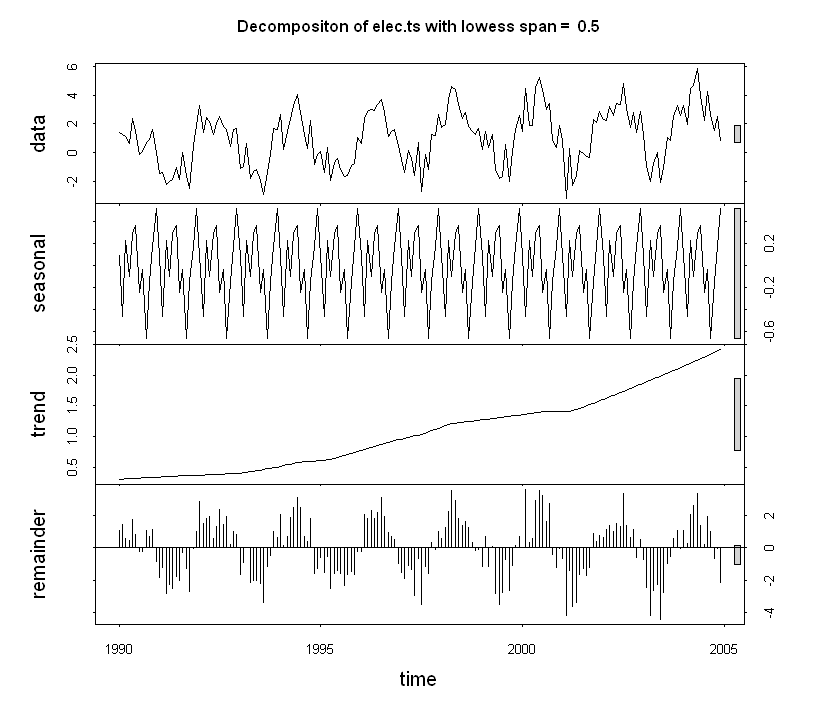

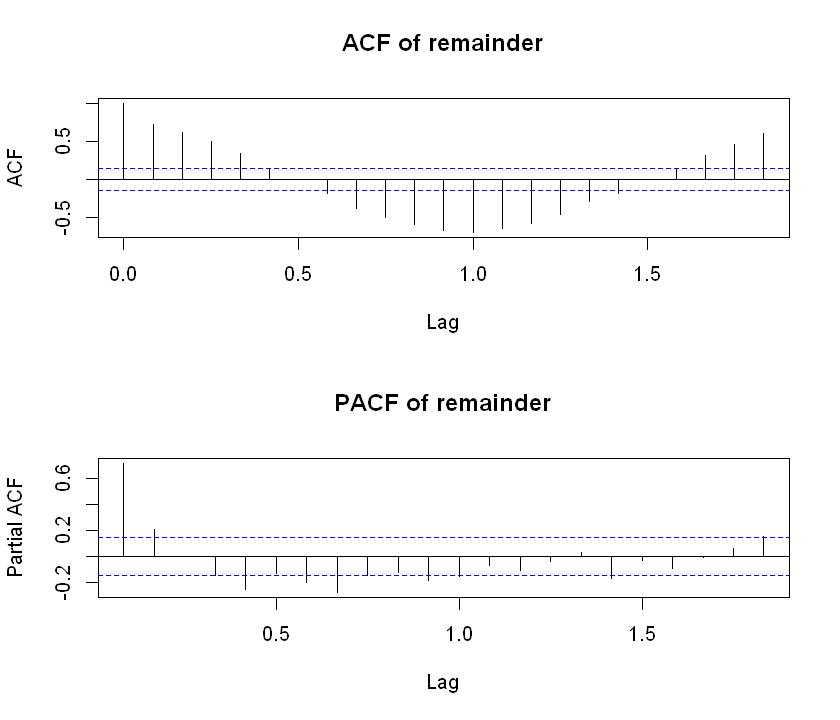

In [21]:
options(repr.pmales.extlot.width=8, repr.plot.height=6)
season.decomp = ts.decomp(season, is.df = FALSE)
plot.acf(season.decomp[,3], is.df = FALSE)

## ARIMA Models for the Residual Series

Now that we have investigated the basic properties of time series and some decomposition methods, let's investigate models for dealing with the residuals. 

### Autoregressiive Model

The values of an **autoregrissive** or **AR** time series are determined by a linear combination of the past values.In other words, the AR model accounts for serial correlation in the values of the time series. We can write the value of an autoregressive series or **order p** or **AR(p)** series at time t as:

$$x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} \dots \alpha_p x_{t-p}$$

An AR process has the following properties:

- $\rho_0 = 1$ always.
- $p_k = \alpha^k$
- Number of nonzero PACF values = p.

Run the code in the cell below which simulates and plots an AR(1), or $x_t = 0.9\ x_{t-1}$, model.

$ar
[1] 0.9

$ma
[1] 0



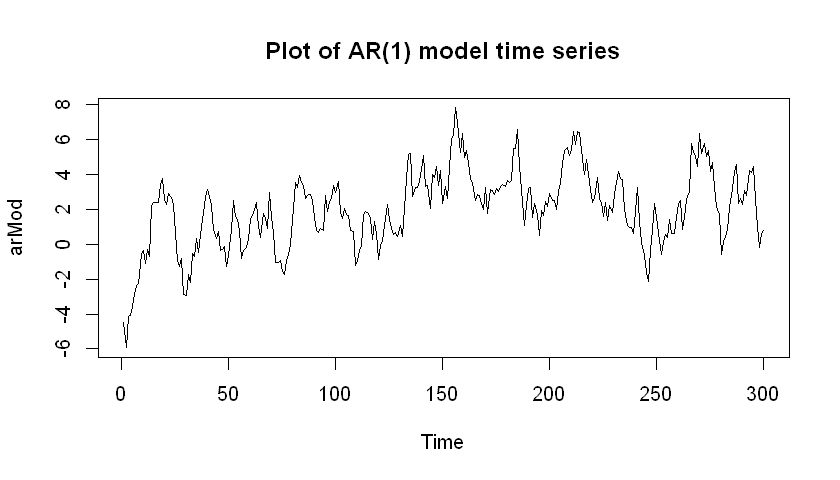

In [66]:
## ---- Simple ARMA models ------
## Simulate an ARMA process
arma.sim = function(ar = c(0.9), ma = c(0), n = 300, mean = 1.0){
  ar1.model = list(ar = ar, ma = ma)
  print(ar1.model)
  ar1 = mean + arima.sim(model = ar1.model, n = n)
  ar1
}
## --- AR(1) process
arMod = arma.sim()
options(repr.pmales.extlot.width=8, repr.plot.height=4)
plot(arMod, main = 'Plot of AR(1) model time series')

The series shows significant deviatiions from the zero, and a bit drift from zero. 

Run the code in the cell below to plot the ACF and PACF of the AR(1) series. 

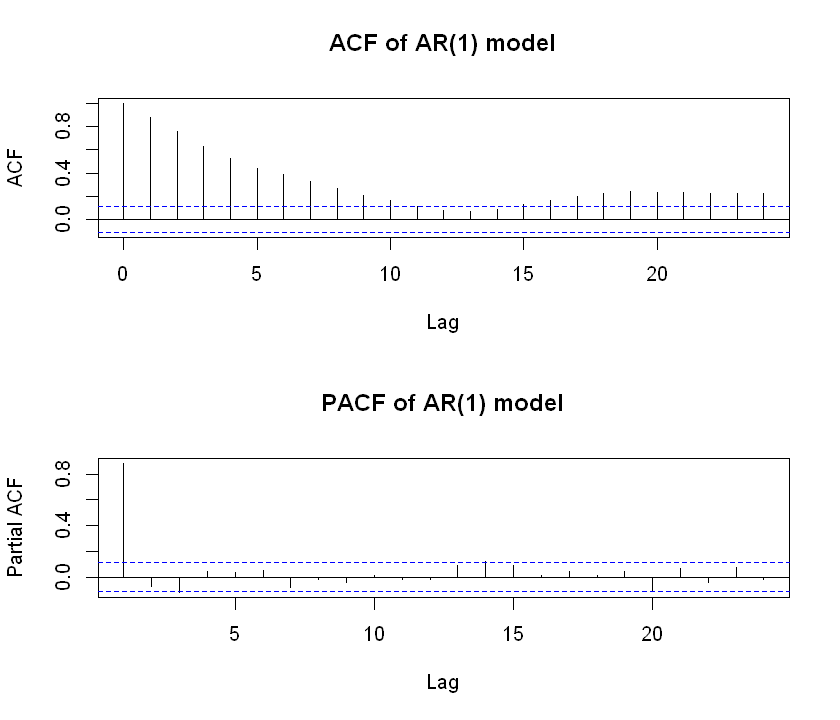

In [68]:
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(arMod, col = 'AR(1) model', is.df = F)

The AR(1) model produces a series with significant correlations in the lags, as shown in the  ACF plot. More importantly, the PACF has 1 significant lag value, consistent  with the AR(1) model. 

The AR time series model estimates the coeficients for the order of the model specified. The order of  the model is specified as the first number in an R vector. Run this code and examine  the  properties of the  results. 


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1
      0.9377
s.e.  0.0193

sigma^2 estimated as 1.039:  log likelihood = -432.52,  aic = 869.04


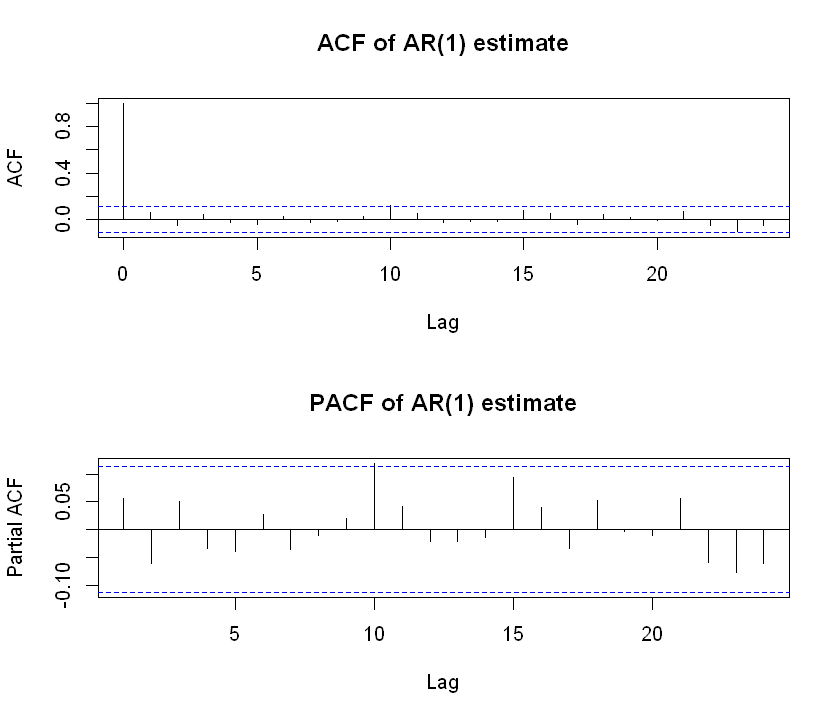

In [24]:
## Function for ARIMA model estimation
ts.model = function(ts, col = 'remainder', order = c(0,0,1)){
  mod = arima(ts, order = order, include.mean = FALSE)
  print(mod)
  mod
}
mod.est = ts.model(arMod, col = 'AR(1) process', order = c(1,0,0))
plot.acf(mod.est$resid[-1], col = 'AR(1) estimate', is.df = F)

Note the following about the AR model:

- The estimated AR coefficient is nearly the same value as the orginal model. Further, the standard error is small relative to the value of the coefficient. 
- On the lag 0 value is  significant in the ACF  plot, indicating the estimate has removed the AR components from the original series. 
- The PACF remains insignificant, as is the case of the original series. 

### Moving Average Model

For a **moving average** or **MA** model the value of the time series at time `t` is determined by a linear combination of past white noise terms. In other words, the MA model accounts for series correlation in the noise terms. We can write the MA(q) model as the linear combination of the last `q` white noise terms $w_i$:

$$x_t = w_t + \beta_1 w_{t-1} + \beta_2 w_{t-2} + \cdots + \beta_q w_{t-q}$$

An MA process has the following properties:

- $\rho_0 = 1$ always.
- Number of nonzero $\rho_k; k \ne 0$ values = q.

The code in the cell below computes an `MA(1)` model with a coeficient $\beta_1 = 0.9$, and plots the results. Run this code and examine these plots.

$ar
[1] 0.001

$ma
[1] 0.9



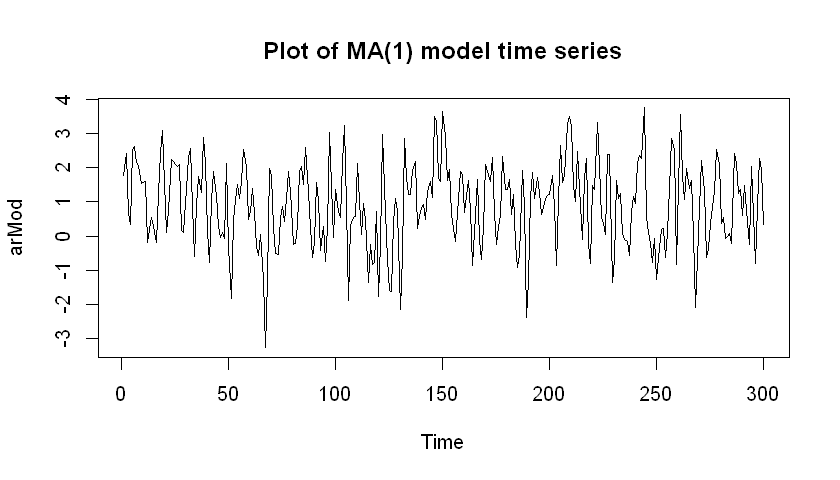

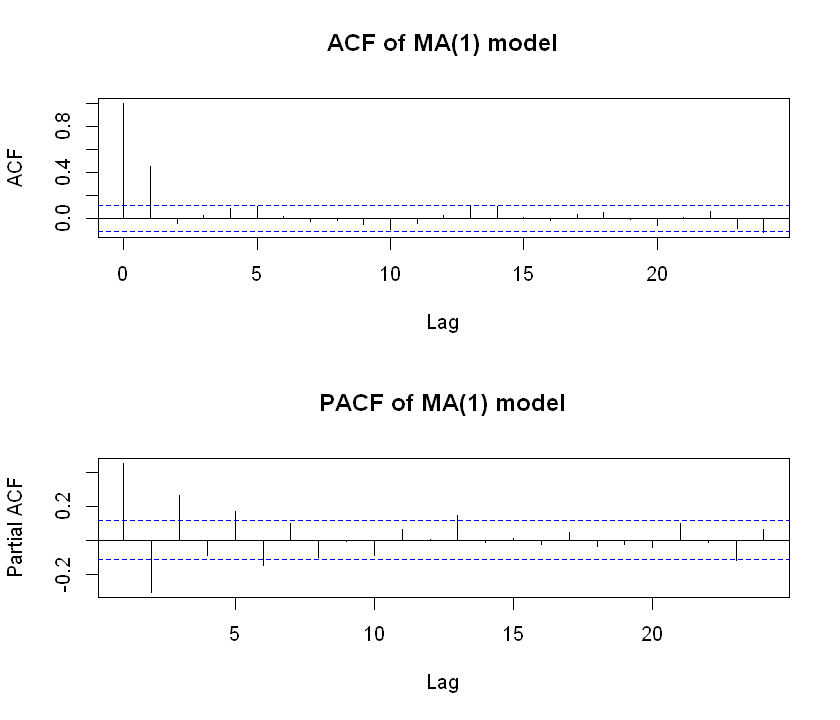

In [69]:
## --- MA(1) process
arMod = arma.sim(ar = c(0.001), ma = (0.9))
options(repr.pmales.extlot.width=8, repr.plot.height=4)
plot(arMod, main = 'Plot of MA(1) model time series')
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(arMod, col = 'MA(1) model', is.df = F)


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ma1
      0.9562
s.e.  0.0205

sigma^2 estimated as 1.154:  log likelihood = -448.4,  aic = 900.8


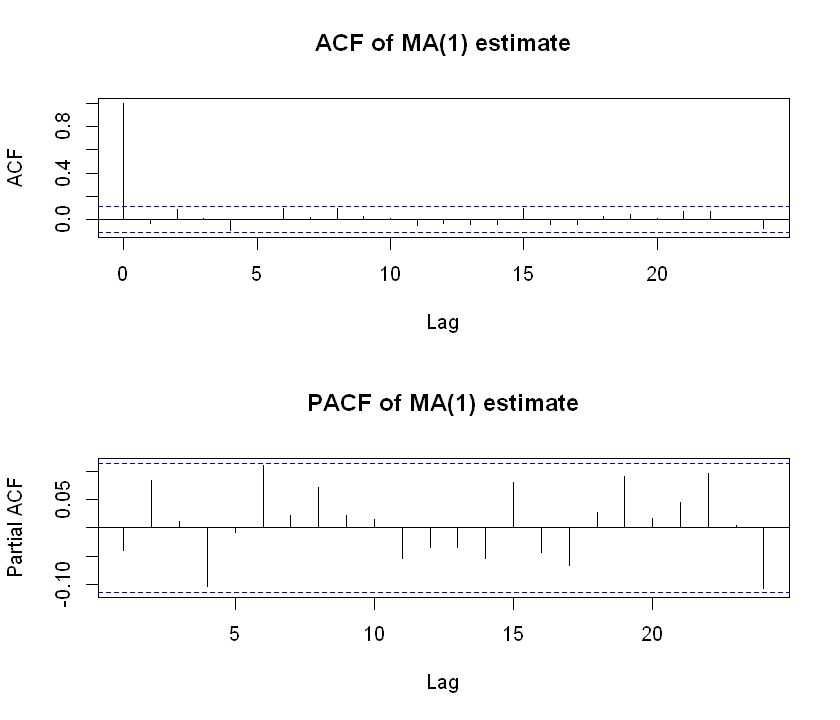

In [26]:
mod.est = ts.model(arMod, col = 'MA(1) process', order = c(0,0,1))
plot.acf(mod.est$resid[-1], col = 'MA(1) estimate', is.df = F)

$ar
[1] 0.9

$ma
[1] 0.9



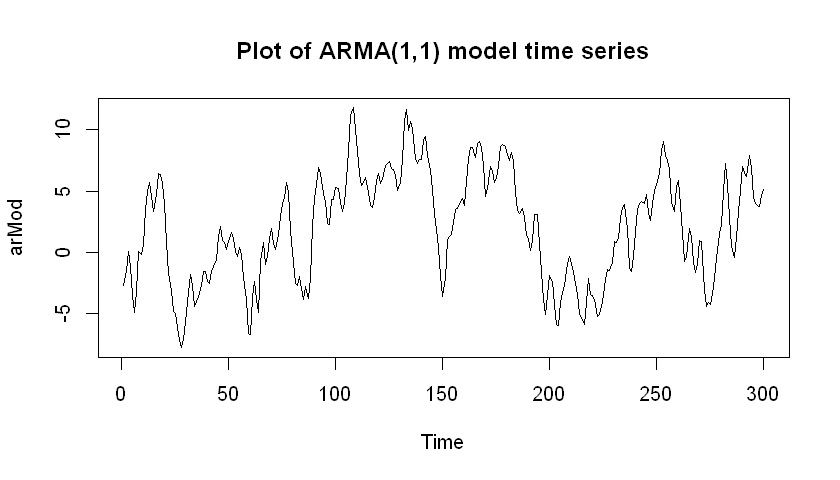

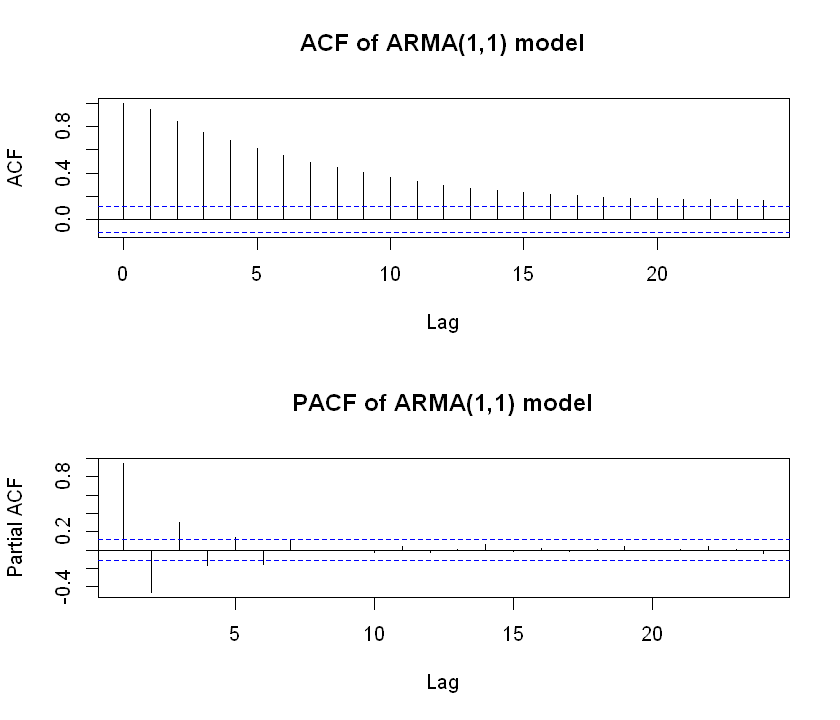

In [27]:
## ---- ARMA(1,1) process
arMod = arma.sim(ar = c(0.9), ma = (0.9))
options(repr.pmales.extlot.width=8, repr.plot.height=4)
plot(arMod, main = 'Plot of ARMA(1,1) model time series')
options(repr.pmales.extlot.width=8, repr.plot.height=6)
plot.acf(arMod, col = 'ARMA(1,1) model', is.df = F)


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1     ma1
      0.9136  0.9217
s.e.  0.0230  0.0246

sigma^2 estimated as 1.091:  log likelihood = -441.15,  aic = 888.31


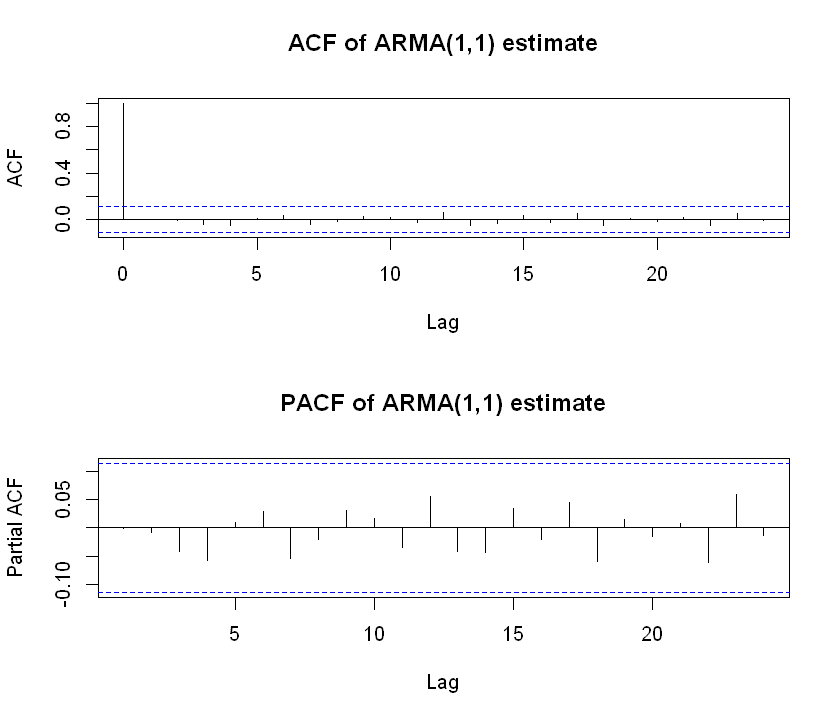

In [28]:
mod.est = ts.model(arMod, col = 'ARMA(1,1) process', order = c(1,0,1))
plot.acf(mod.est$resid[-1], col = 'ARMA(1,1) estimate', is.df = F)

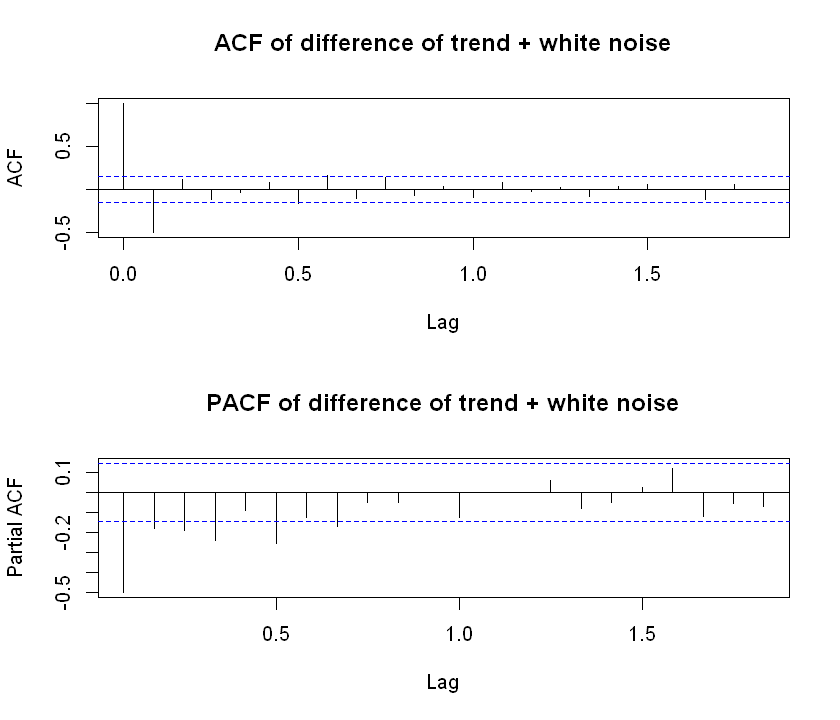

In [29]:
## ARMA model of trend difference process
plot.acf(diff.out, col = 'difference of trend + white noise', is.df = F)


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1      ma1
      0.0566  -0.7984
s.e.  0.0900   0.0487

sigma^2 estimated as 1.102:  log likelihood = -263.12,  aic = 532.23


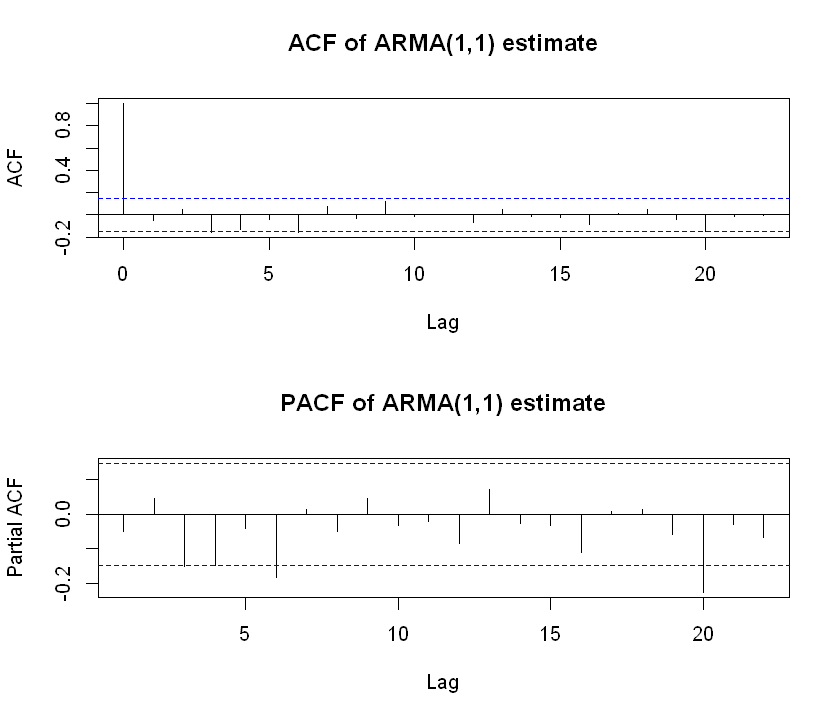

In [30]:
diff.est = ts.model(diff.out, col = 'ARMA(1,1) process', order = c(1,0,1))
plot.acf(diff.est$resid[-1], col = 'ARMA(1,1) estimate', is.df = F)

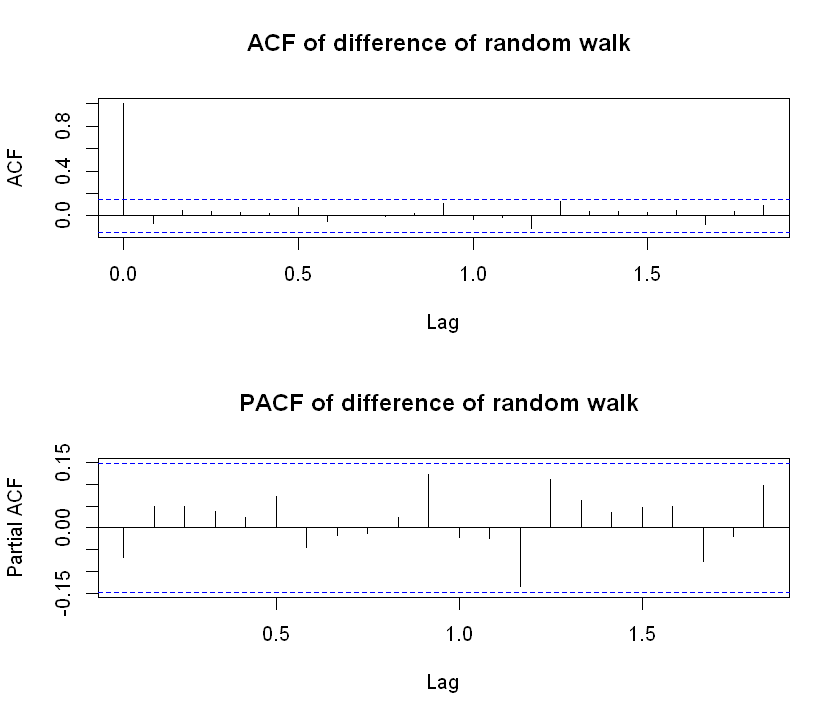

In [31]:
## ARMA model of the random walk difference process 
plot.acf(diff.walk, col = 'difference of random walk ', is.df = F)


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1      ma1
      0.0566  -0.7984
s.e.  0.0900   0.0487

sigma^2 estimated as 1.102:  log likelihood = -263.12,  aic = 532.23


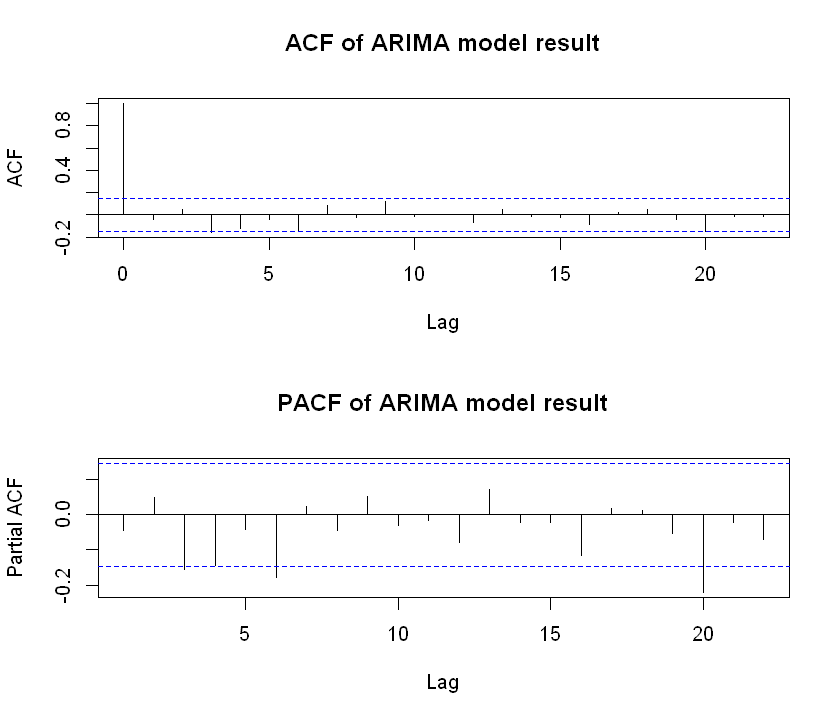

In [32]:
## --- ARIMA modeling of trend series
arima.est = ts.model(trend, col = 'ARIMA process model', order = c(1,1,1))
plot.acf(arima.est$resid[-1], col = 'ARIMA model result', is.df = F)


Call:
arima(x = ts, order = order, include.mean = FALSE)


sigma^2 estimated as 0.8859:  log likelihood = -243.14,  aic = 488.29


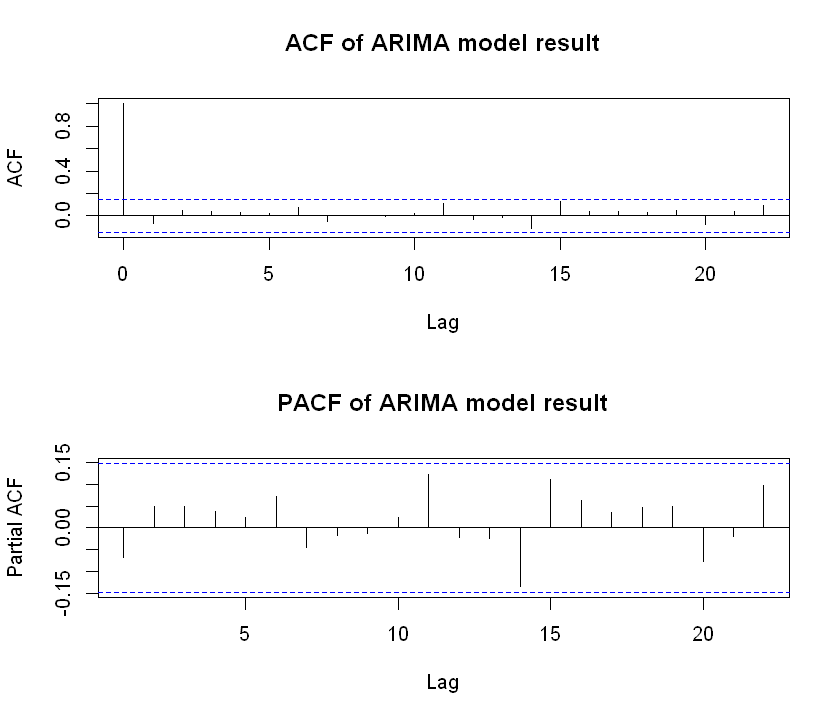

In [33]:
## ARIMA modeling of random walk with first order diff
arima.walk = ts.model(ranWalk, col = 'ARIMA process model', order = c(0,1,0))
plot.acf(arima.walk$resid[-1], col = 'ARIMA model result', is.df = F)


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
          ar1
      -0.0705
s.e.   0.0759

sigma^2 estimated as 0.8816:  log likelihood = -242.71,  aic = 489.43


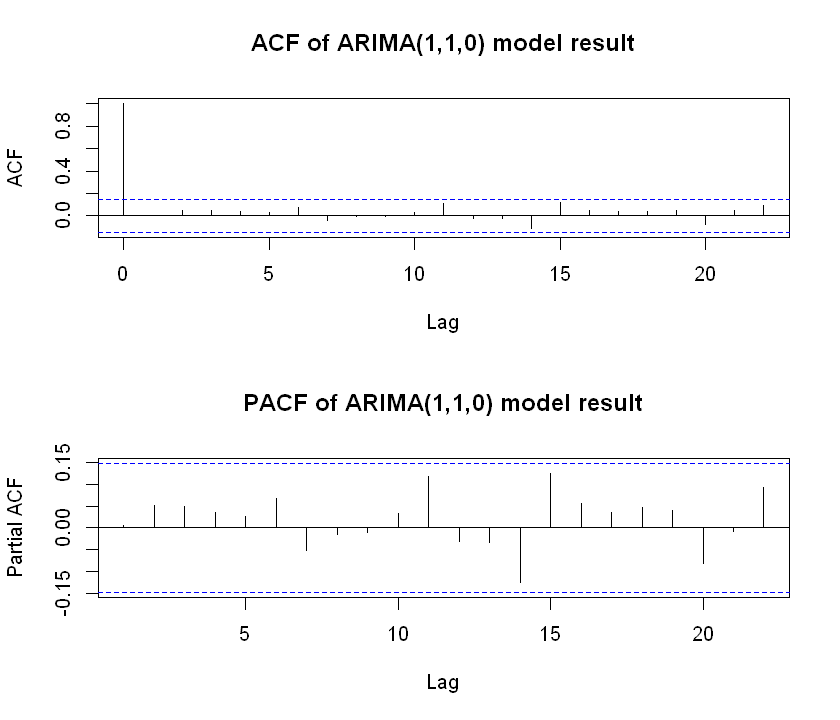

In [34]:
## ARIMA modeling of random walk with ARIMA(1,1,0)
arima.walk = ts.model(ranWalk, col = 'ARIMA(1,1,0) process model', order = c(1,1,0))
plot.acf(arima.walk$resid[-1], col = 'ARIMA(1,1,0) model result', is.df = F)

In [35]:
### ------- Real world data sets ------------
#
# --------Electricity, beer, and chocolate ----
#
# Load the data from the Internet
#www = "http://www.maths.adelaide.edu.au/emac2009/#Data/cbe.dat"
getwd()
CBE = read.table('cbe.dat', sep ="", header = TRUE)
head(CBE)

[1] "C:/Users/StevePC2/Documents/JupyterNotebooks/DataScience350/Lecture8"

choc,beer,elec
1451,96.3,1497
2037,84.4,1463
2477,91.2,1648
2785,81.9,1595
2994,80.5,1777
2681,70.4,1824


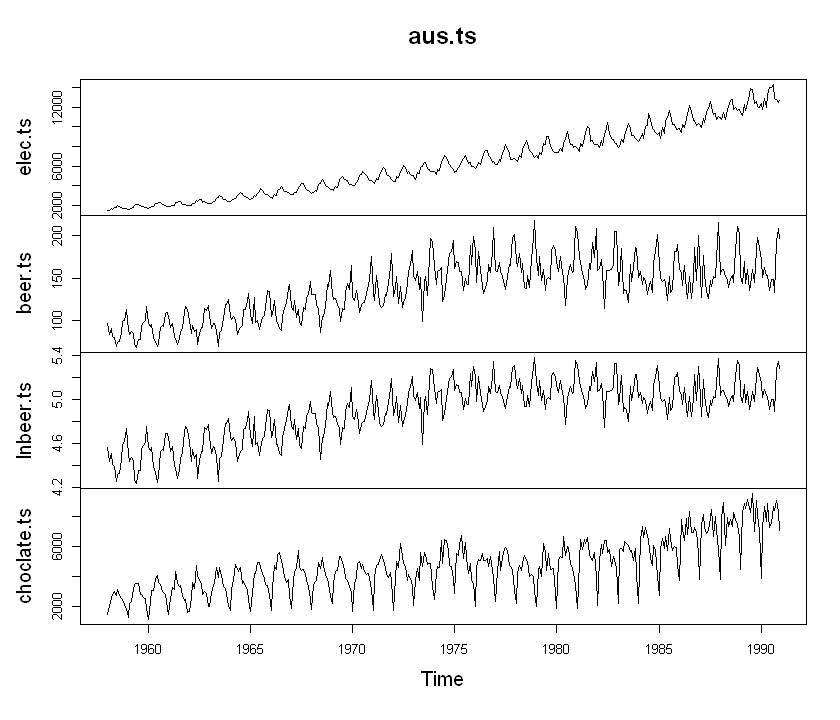

In [36]:
elec.ts = ts(CBE[,3], start = 1958, freq = 12)
beer.ts = ts(CBE[,2], start = 1958, freq = 12)
lnbeer.ts = ts(log(CBE[,2]), start = 1958, freq = 12)
choclate.ts = ts(CBE[,1], start = 1958, freq = 12)
aus.ts = cbind(elec.ts, beer.ts, lnbeer.ts, choclate.ts)
## First look at the series
plot(aus.ts)

In [37]:
## --- The beer consumption time series
## Find an ARIMA model of beer
beer.arima = ts.model(aus.ts[,'beer.ts'], col = 'ARIMA model for beer', order = c(1,1,1))


Call:
arima(x = ts, order = order, include.mean = FALSE)

Coefficients:
         ar1      ma1
      0.4772  -0.9452
s.e.  0.0475   0.0122

sigma^2 estimated as 306.5:  log likelihood = -1691.84,  aic = 3389.68
